# Seattle Airbnb Data: What Makes a Superhost?

## Importing Libraries

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import spacy
import gensim
from gensim.models import  Phrases
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk import ngrams

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import re
import joblib

from typing import List

C:\Users\idocarmo\Miniconda3\envs\airbnb\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Loading Data

In [2]:
df_listing = pd.read_csv('data/listings.csv')
df_reviews = pd.read_csv('data/reviews.csv')

### Taking a peak at the fields

In [3]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


## What About Superhosts?

#### How many places have superhosts?

In [5]:
# Just checking if the id is unique
df_listing.id.nunique() == len(df_listing)

True

In [6]:
df_listing.host_is_superhost.value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

In [7]:
df_listing.host_is_superhost.value_counts()/df_listing.host_is_superhost.value_counts().sum()

f    0.796122
t    0.203878
Name: host_is_superhost, dtype: float64

There are 778 places superhosts which is equivalent of 20.39% of the places.

### Are Supehosts Cancellation Policy more Flexible? 

Let's crate data frames for common host and super hosts

In [152]:
df_listing_superhost = df_listing.loc[df_listing.host_is_superhost=='t']
df_listing_commonhost = df_listing.loc[df_listing.host_is_superhost=='f']

We check then the cancelation policy for the superhosts

In [155]:
df_listing_superhost.cancellation_policy.value_counts()/len(df_listing_superhost)

strict      0.430591
moderate    0.386889
flexible    0.182519
Name: cancellation_policy, dtype: float64

and for the common hosts

In [156]:
df_listing_commonhost.cancellation_policy.value_counts()/len(df_listing_commonhost)

strict      0.356155
flexible    0.331468
moderate    0.312377
Name: cancellation_policy, dtype: float64

We can conclude that no, cancelation superhost's cancellation policy isn't more flexible for superhosts. Actually, they are more strinct. 
While for commom hosts approximately 64% of then have flexible or moderate cancellation policy, for superhosts this number drops to 57%.

### Are Superhosts More Careful with Cleaning?

To answer this let's check the boxplot of the cleanliness review for each type of host:

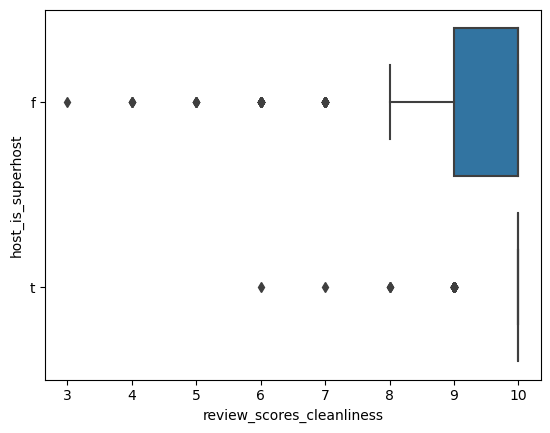

In [180]:
sns.boxplot(data=df_listing, 
            x='review_scores_cleanliness', 
            y='host_is_superhost')
plt.show()

Oh. Seems like superhost are distiguashable for they care with cleaning. Anything different of 10 out 10 is a outliar for then.

Another way to see the same:

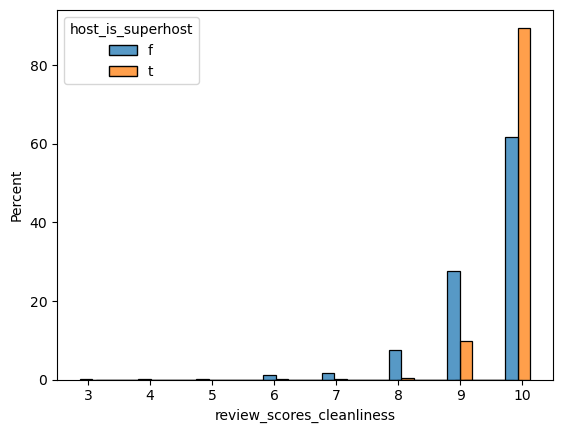

In [181]:
sns.histplot(data=df_listing, x='review_scores_cleanliness', 
             hue='host_is_superhost', 
             multiple="dodge", 
             stat="percent", 
             common_norm=False, 
             shrink=3)
plt.show()

## NLP Analysis

#### Superhosts and Their Reviews Comments

In [8]:
df_superhosts_id = df_listing.loc[df_listing.host_is_superhost=='t', ['id', 'number_of_reviews']]

In [9]:
df_superhosts_id.number_of_reviews.sum()

32487

So there are 32487 text reviews for superhosts. That seems like a good number of texts for NLP analisys.

32487 is also the number of records we expect to have when joining the superhosts id dataframe with the reviews dataframe. Let's see:

In [10]:
df_superhost_reviews = df_reviews.merge(df_superhosts_id.id, 
                                        how='inner', 
                                        left_on='listing_id', 
                                        right_on='id')

In [11]:
len(df_superhost_reviews)

32487

Lucky us, the values match. Let's follow with our analysis.

### What Does Review Comments Say?

Let's check the distribution of number of characters for the review comments.

In [12]:
df_superhost_reviews = df_superhost_reviews[['listing_id', 'comments']]
df_superhost_reviews.loc[:,'comments'] = df_superhost_reviews.loc[:,'comments'].astype(str)
df_superhost_reviews.head(5)

,listing_id,comments
0,8308353,"Courtney was so welcoming, I immediately felt ..."
1,8308353,We felt very welcomend in courtney and adams a...
2,8308353,"Great place, fantastic hosts. Definitely what ..."
3,8308353,This was a beautiful bright room with two wind...
4,8308353,It was magnificent! The place was beautiful ...


In [13]:
df_superhost_reviews['comment_lenght'] = df_superhost_reviews.comments.apply(len)
df_superhost_reviews.head(5)

,listing_id,comments,comment_lenght
0,8308353,"Courtney was so welcoming, I immediately felt ...",375
1,8308353,We felt very welcomend in courtney and adams a...,414
2,8308353,"Great place, fantastic hosts. Definitely what ...",179
3,8308353,This was a beautiful bright room with two wind...,248
4,8308353,It was magnificent! The place was beautiful ...,173


In [14]:
df_superhost_reviews.comment_lenght.describe()

count    32487.000000
mean       404.641918
std        293.783096
min          1.000000
25%        211.000000
50%        337.000000
75%        514.000000
max       3472.000000
Name: comment_lenght, dtype: float64

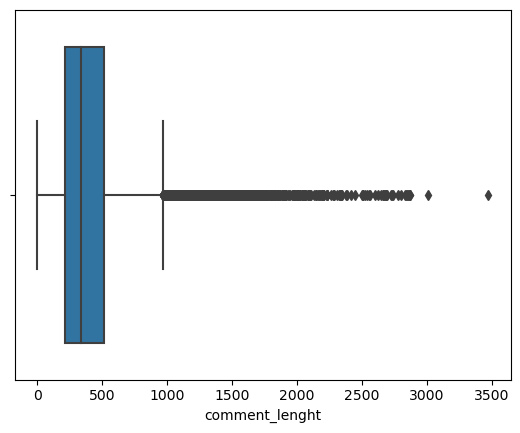

In [16]:
sns.boxplot(x=df_superhost_reviews['comment_lenght'])
plt.show()

Let's get only the comments with number of characters above the first quantile so we have more elaborate comments

In [17]:
df_superhost_reviews = df_superhost_reviews[df_superhost_reviews.comment_lenght > 211]

### Text Processing

We start defining our language model and its respective stopwords

In [100]:
# To download the language package run
# python -m spacy download en_core_web_sm
nlp_model = spacy.load('en_core_web_sm')

# English stop words
stop_words = nlp_model.Defaults.stop_words

Let's add to the stop words some terms that are commom to the review comment context but do not add any information to our analysis.

In [ ]:
stop_words.add('seattle')
stop_words.add('stay')
stop_words.add('recommend')

We then define a funcion to clean our data:

In [101]:
def process_english_text(textstring: str) -> list:
    """Process a text string comment.
    
    Strips special characters, extra spaces 
    and transform to lowercase. 
    Tokenize, remove stop words and lemmatize the tokens

    Args:
      textstring:
        plain text string.

    Returns:
      List of lemmatized tokens of the comment.
    """

    # Keep only alphabet letters
    textstring = re.sub(r'[^a-zA-Z\s]', ' ', textstring, re.I|re.A)
    textstring = re.sub('\n', ' ', textstring)
    textstring = re.sub('\r', ' ', textstring)

    # Transform to lower case
    textstring = textstring.lower()
    
    # Strip extra white spaces
    textstring = textstring.strip()
    textstring = re.sub(' +', ' ', textstring)

    doc = nlp_model(textstring)

    tokens = []
    
    for token in doc:
      token = token.lemma_
      if (token not in stop_words) and (len(token)>1):
        tokens.append(token)

    return tokens 

And use this function to create our corpus of comments in the form of tokens:

In [102]:
comments_tokens = df_superhost_reviews.comments.apply(process_english_text).values

In [103]:
# Save the processed data so we do not have do to it again 
joblib.dump(comments_tokens, 'comments_tokens.sav')

['comments_tokens.sav']

In [104]:
# Loads the processed data
# comments_tokens = joblib.load('comments_tokens.sav')

### Bi-gram Word Cloud

Let's define a function to create bi-grams

In [105]:
def build_ngrams(corpus_texts:List[list], n: int=2) -> List[list]:
    """Build a ngrams from tokenized corpus.
    
    Build a ngrams representation for the corpus.

    Args:
      corpus_texts:
        Corpus as a list of tokenized documents 
        (list of lists of strings)
      n:
        ngrams order. Ex: n=2 is a bigram.

    Returns:
      List of ngrams representation of corpus' documents.
    """

    ngrams_string_list = []
    
    ngrams_tuple_list = list(ngrams(corpus_texts, n))

    for term in ngrams_tuple_list:
        my_string = " ".join(term)
        ngrams_string_list.append(my_string)

    return ngrams_string_list

And create our bigrams corpus

In [106]:
bigram_comments = list(map(build_ngrams, comments_tokens))

In [107]:
bigram_dictionary = Dictionary(bigram_comments)

bigram_dictionary.filter_extremes(no_below=10, no_above=0.7)

bigram_corpus = [bigram_dictionary.doc2bow(comment) for comment in bigram_comments]

temp = bigram_dictionary[0]
bigram_id2word = bigram_dictionary.id2token

We then transform this corpus with TF-IDF

In [108]:
tfidf_bigram = TfidfModel(bigram_corpus, normalize=True)
bigram_corpus_transformed = tfidf_bigram[bigram_corpus]

And count the frequency of terms 

In [182]:
# Transform the corpus to a numpy array
corpus_matrix = gensim.matutils.corpus2csc(bigram_corpus_transformed)
corpus_matrix = corpus_matrix.todense().T

In [111]:
# Transform the array to a dataframe
df_corpus = pd.DataFrame(corpus_matrix)
df_corpus.rename(columns=bigram_id2word, inplace=True)
df_corpus.head()

,attend wedding,bed great,easy walking,feel home,floor room,gas work,good view,great house,house easy,immediately feel,...,eleanor bruce,thank eleanor,shawn cottage,carolyn james,barbara michael,martin carolyn,rick jeff,hal fantastic,tiny guestyhouse,hal tiny
0,0.300409,0.213835,0.192637,0.141074,0.297454,0.243629,0.239428,0.217496,0.225074,0.236855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# Count the term frequency
df_frequency = df_corpus.sum(axis=0)

So we can finally create the word cloud

In [117]:
cloud = WordCloud(background_color="white", width=1000, height=600, max_words=50).generate_from_frequencies(df_frequency);

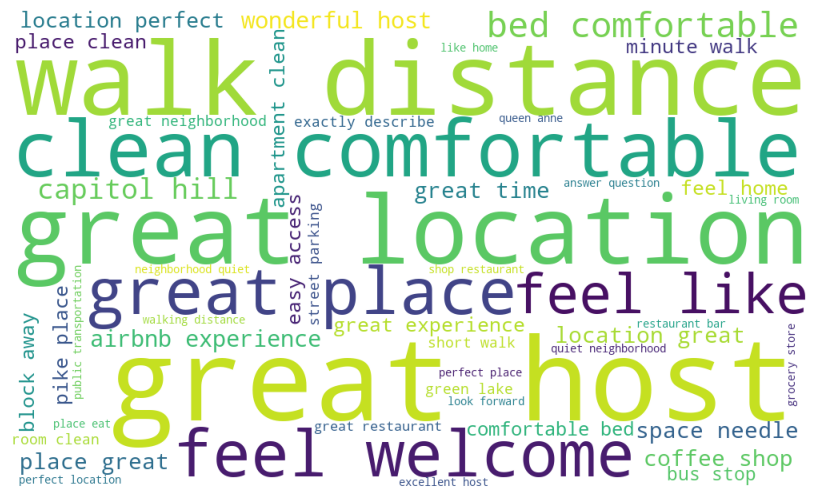

In [118]:
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### LDA Topic Modelling

We repeate here the process to create the corpus but now for uni-grams not bi-grams.

In [122]:
dictionary = Dictionary(comments_tokens)

In [123]:
dictionary.filter_extremes(no_below=10, no_above=0.7)

corpus = [dictionary.doc2bow(comments) for comments in comments_tokens]

temp = dictionary[0]
id2word = dictionary.id2token

With this new corpus we can run Gensim's LDA model

In [129]:
model = LdaModel(corpus=corpus, id2word=dictionary, 
                alpha="auto", eta="auto", 
                random_state=0, iterations=500, 
                num_topics=5, passes=20, eval_every=None)
top_topics = list(model.top_topics(corpus))

And vizualize it with pyLDAvis

In [130]:
lda_viz = gensimvis.prepare(model, corpus, dictionary)

C:\Users\idocarmo\Miniconda3\envs\airbnb\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [131]:
pyLDAvis.display(lda_viz)

In [132]:
pyLDAvis.save_html(lda_viz, 'airbnb_lda.html')